In [1]:
import sys
import os

import matplotlib.pyplot as plt

from Mala.mala import MALAKernel

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *

In [3]:
data = [{"type": "Smooth", "results": []}, {"type": "Rough", "results": []}]

In [4]:
def run(f0, dim_parameters, dim_observations, p, num_particles, noise_level=1e-6):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = LinearForwardModel(dim_parameters, dim_observations, p, coef=1)
    # i_array =jnp.linspace(1, dim_parameters, dim_parameters)

    y_true = forward_model.evaluate(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    # plt.plot(i_array, f0)
    # plt.plot(i_array, y_true)
    # plt.show()

    plt.show()
    prior_cov = GaussianKernel(dim_parameters, 1)._operator_fourier
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=jnp.zeros(dim_parameters),
        noise_level=noise_level,
        time_interval=(1, 150.0, 200),  # (start, end, max_steps)
        rng_key=key,
    )

    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=1,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results

In [5]:
# global parameters
dim_parameters = 100
dim_observations = 100
p = 1 / 2
beta = 1
num_particles = 100

noise_levels = [1e-2, 1e-4, 1e-6, 1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [6]:
i_array = jnp.linspace(1, dim_parameters, dim_parameters)

frough = jnp.apply_along_axis(
    lambda x: (5 * jnp.sin(0.5 * x)) * x ** (-beta), 0, i_array
)
fsmooth = jnp.apply_along_axis(lambda x: (5 * jnp.exp(-x)), 0, i_array)

In [7]:
data[0]["f0"] = fsmooth
data[1]["f0"] = frough

In [8]:
for i in range(len(data)):
    f0 = data[i]["f0"]
    results_list = []
    for noise_level in noise_levels:
        results = run(
            f0, dim_parameters, dim_observations, p, num_particles, noise_level
        )
        results_list.append(results)
    data[i]["results"] = results_list

norm ensemble 12.409481
norm ensemble 12.409481
norm ensemble 12.409481
norm cross_cov 0.90914327
2.6319747
norm ensemble 20.680422
norm ensemble 20.680422
norm cross_cov 0.23761357
2.12058
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.114013
norm ensemble 12.409481
norm ensemble 12.409481
norm ensemble 12.409481
norm cross_cov 0.90914327
12.228611
norm ensemble 20.778849
norm ensemble 20.778849
norm cross_cov 0.22739752
9.790912
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.008022
norm ensemble 12.409481
norm ensemble 12.409481
norm ensemble 12.409481
norm cross_cov 0.90914327
42.647934
norm ensemble 20.716805
norm ensemble 20.716805
norm cross_cov 0.22728677
35.125698
converged

Algorithm converged: True
Stopping time: 2
Final residual: 0.002309
norm ensemble 12.409481
norm ensemble 12.409481
norm ensemble 12.409481
norm cross_cov 0.90914327
65.88962
norm ensemble 20.71179
norm ensemble 20.71179
norm cross_cov 0.22728626
62.60499
co

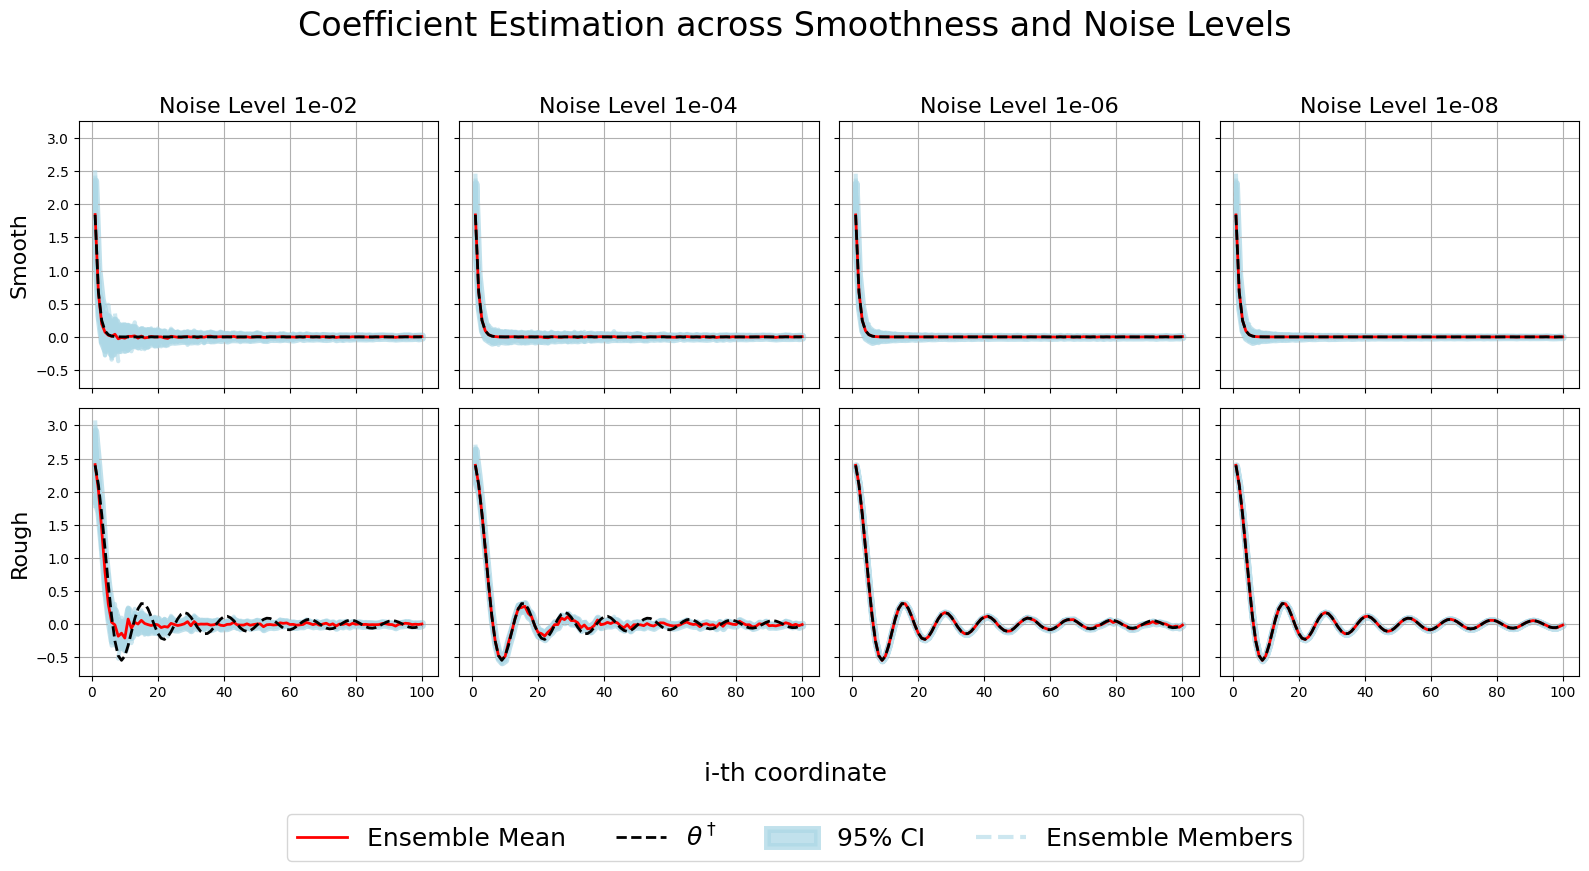

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

i_array = jnp.linspace(1, 100, 100)
q = jnp.array([0.025, 0.975])

num_experiments = len(data)
num_levels = len(data[0]["results"])  # assuming same number of noise levels for each

fig, axes = plt.subplots(
    num_experiments,
    num_levels,
    figsize=(4 * num_levels, 4 * num_experiments),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one experiment or one noise level
if num_experiments == 1:
    axes = [axes]
if num_levels == 1:
    axes = [[ax] for ax in axes]

# Loop over experiments (rows)
for row_idx, item in enumerate(data):
    f0 = item["f0"]
    type_label = item["type"]

    for col_idx, results in enumerate(item["results"]):
        ax = axes[row_idx][col_idx]
        hat_coefs_f0_ensemble = results["ensemble_history"][-1]

        # Plot individual ensemble members
        ensemble_members_handle = ax.plot(
            i_array,
            hat_coefs_f0_ensemble,
            color="lightblue",
            linestyle="dashed",
            alpha=0.6,
            linewidth=3,
        )

        # Ensemble mean
        (ensemble_mean_handle,) = ax.plot(
            i_array,
            jnp.mean(hat_coefs_f0_ensemble, axis=1),
            color="red",
            linewidth=2,
            label="ensemble mean",
        )

        # True v0
        (f0_handle,) = ax.plot(
            i_array,
            f0,
            color="black",
            label=r"$\theta^\dagger$",
            linestyle="dashed",
            linewidth=2,
        )

        # Quantiles
        quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
        fill_handle = ax.fill_between(
            i_array,
            quantiles[0],
            quantiles[1],
            color="lightblue",
            alpha=0.75,
            label="95% CI",
            linewidth=5,
        )
        ax.grid(True)
        # Axis labels
        if col_idx == 0:
            ax.set_ylabel(f"{type_label}", fontsize=16)
        if row_idx == 0:
            ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
fig.supxlabel("i-th coordinate", fontsize=18)
# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$\theta^\dagger$", "95% CI", "Ensemble Members"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.1)
)

# Main title
fig.suptitle(r"Coefficient Estimation across Smoothness and Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()